In [1]:
##Notebook to estimate and collate confoudners for PA Mathcing study
##Assing treatment and control to plots and calcaute distance to the nearest road and river and combine with values from GEE

In [2]:
library(tidyverse)
library(sf)
library(cowplot)
library(MetBrewer)
library(raster)
library(ggspatial)

── Attaching packages ─────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.1.1     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Linking to GEOS 3.10.0, GDAL 3.3.3, PROJ 8.1.1; sf_use_s2() is TRUE

Loading required package: sp

Warning message:
“multiple methods tables found for ‘direction’”
Warning message:
“multiple methods tables found for ‘gridDistance’”

Attaching package: ‘raster’


The following object is masked from ‘package:dplyr’:

    select




In [3]:
path <- 'PATH/TO/DATA'

In [4]:
##read in the ILUAII plots and confoudners from GEE
##link to script to create confounders https://code.earthengine.google.com/a48c95248138b7adefbceba42613beff
plots <- st_read(paste0(path,'iluaii/polys.shp'))
p_detail <- read_csv(paste0(path,'iluaii/plots.csv'))
conf <- read_csv(paste0(path,'zam_plot_gee_conf.csv'))

Reading layer `polys' from data source 
  `/exports/csce/datastore/geos/users/s0834538/pa_matching_data/iluaii/polys.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 3886 features and 1 field
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: 22.0022 ymin: -17.9008 xmax: 33.50685 ymax: -8.493116
Geodetic CRS:  WGS 84


Rows: 3886 Columns: 183

── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (16): plot_id, plot_cluster, plot_name, country_iso3, prinv, plot_shape,...
dbl (73): first_census, last_census, all_dates, plot_width, plot_length, min...
lgl (94): other_authors, plot_diameter, subplot_n, subplot_shape, subplot_le...


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

Rows: 3886 Columns: 8

── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (1): plot_id
dbl (7): elevation, slope, travel_time_city_2015, precipitation, treecover_2...


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



In [5]:
st_bbox(plots)

      xmin       ymin       xmax       ymax 
 22.002200 -17.900797  33.506850  -8.493116 

In [6]:
##set bounding box slightly bigger than plots to get nearby roads and rivers
zam_box = c(xmin = 21.5, ymin = -18.5, xmax = 34, ymax = -7.5)

In [7]:
##read in the roads and river datasets 
roads <- st_read(paste0(path,'groads-v1-africa-shp/gROADS-v1-africa.shp')) %>% st_crop(zam_box)
rivers <- st_read(paste0(path,'HydroRIVERS_v10_af_shp/HydroRIVERS_v10_af.shp')) %>% st_crop(zam_box)

Reading layer `gROADS-v1-africa' from data source 
  `/exports/csce/datastore/geos/users/s0834538/pa_matching_data/groads-v1-africa-shp/gROADS-v1-africa.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 585413 features and 36 fields
Geometry type: MULTILINESTRING
Dimension:     XY
Bounding box:  xmin: -31.25769 ymin: -49.39616 xmax: 72 ymax: 42
Geodetic CRS:  WGS 84


Warning message:
“attribute variables are assumed to be spatially constant throughout all geometries”


Reading layer `HydroRIVERS_v10_af' from data source 
  `/exports/csce/datastore/geos/users/s0834538/pa_matching_data/HydroRIVERS_v10_af_shp/HydroRIVERS_v10_af.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 1527551 features and 14 fields
Geometry type: LINESTRING
Dimension:     XY
Bounding box:  xmin: -17.99375 ymin: -34.79375 xmax: 54.41667 ymax: 37.33125
Geodetic CRS:  WGS 84


Warning message:
“attribute variables are assumed to be spatially constant throughout all geometries”


In [8]:
##read in Zambian outline for map
zam <- st_read(dsn = paste0(path,'gadm36_ZMB_shp'), layer = 'gadm36_ZMB_0') %>%
           dplyr::select(NAME_0)

##read in Zambian provinces
adm_1 <- st_read(dsn = paste0(path,'gadm36_ZMB_shp'), layer = 'gadm36_ZMB_1') %>%
            dplyr::select(NAME_1) %>%
            st_buffer(1000)

##get polygon of Lusaka city
lusaka <- st_read(dsn = paste0(path,'gadm36_ZMB_shp'), layer = 'gadm36_ZMB_2') %>%
                filter(NAME_2 == 'Lusaka')

Reading layer `gadm36_ZMB_0' from data source 
  `/exports/csce/datastore/geos/users/s0834538/pa_matching_data/gadm36_ZMB_shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 1 feature and 2 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: 21.99937 ymin: -18.07947 xmax: 33.7057 ymax: -8.270877
Geodetic CRS:  WGS 84
Reading layer `gadm36_ZMB_1' from data source 
  `/exports/csce/datastore/geos/users/s0834538/pa_matching_data/gadm36_ZMB_shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 10 features and 10 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: 21.99937 ymin: -18.07947 xmax: 33.7057 ymax: -8.270877
Geodetic CRS:  WGS 84
Reading layer `gadm36_ZMB_2' from data source 
  `/exports/csce/datastore/geos/users/s0834538/pa_matching_data/gadm36_ZMB_shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 72 features and 13 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: 21.9993

In [9]:
##read in the urban extent layer 
settle1 <- raster(paste0(path,'GHS_SMOD/GHS_SMOD_POP2015_GLOBE_R2019A_54009_1K_V2_0_21_10/GHS_SMOD_POP2015_GLOBE_R2019A_54009_1K_V2_0_21_10.tif'))
settle2 <- raster(paste0(path,'GHS_SMOD/GHS_SMOD_POP2015_GLOBE_R2019A_54009_1K_V2_0_20_11/GHS_SMOD_POP2015_GLOBE_R2019A_54009_1K_V2_0_20_11.tif'))
settle3 <- raster(paste0(path,'GHS_SMOD/GHS_SMOD_POP2015_GLOBE_R2019A_54009_1K_V2_0_20_10/GHS_SMOD_POP2015_GLOBE_R2019A_54009_1K_V2_0_20_10.tif'))

In [10]:
##read in ecoregions
eco <- st_read(dsn = paste0(path,'Ecoregions2017'), layer = 'Ecoregions2017') %>%
        dplyr::select(BIOME_NUM) %>%
        st_make_valid() %>%
        st_buffer(1000)

##read in White's veg map
veg_map <- st_read(dsn = paste0(path,'whitesveg'), layer = 'Whites vegetation')

st_crs(veg_map) = 4326
    
## read in agricultrual suitabilty map
agri <- raster(paste0(path, 'Map6_63/comb_int/w001001.adf'))

Reading layer `Ecoregions2017' from data source 
  `/exports/csce/datastore/geos/users/s0834538/pa_matching_data/Ecoregions2017' 
  using driver `ESRI Shapefile'
Simple feature collection with 847 features and 15 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -180 ymin: -89.89197 xmax: 180 ymax: 83.62313
Geodetic CRS:  WGS 84
Reading layer `Whites vegetation' from data source 
  `/exports/csce/datastore/geos/users/s0834538/pa_matching_data/whitesveg' 
  using driver `ESRI Shapefile'
Simple feature collection with 20 features and 3 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -17.53975 ymin: -34.79092 xmax: 51.40255 ymax: 37.4095
CRS:           NA


In [11]:
##read in the Protected areas in Zambia
pas <- st_read(paste0(path,'WDPA_WDOECM_Mar2022_Public_ZMB_shp/WDPA_WDOECM_Mar2022_Public_ZMB_shp_0/WDPA_WDOECM_Mar2022_Public_ZMB_shp-polygons.shp')) %>%
        bind_rows(st_read(paste0(path,'WDPA_WDOECM_Mar2022_Public_ZMB_shp/WDPA_WDOECM_Mar2022_Public_ZMB_shp_1/WDPA_WDOECM_Mar2022_Public_ZMB_shp-polygons.shp'))) %>%
        bind_rows(st_read(paste0(path,'WDPA_WDOECM_Mar2022_Public_ZMB_shp/WDPA_WDOECM_Mar2022_Public_ZMB_shp_2/WDPA_WDOECM_Mar2022_Public_ZMB_shp-polygons.shp')))

Reading layer `WDPA_WDOECM_Mar2022_Public_ZMB_shp-polygons' from data source 
  `/exports/csce/datastore/geos/users/s0834538/pa_matching_data/WDPA_WDOECM_Mar2022_Public_ZMB_shp/WDPA_WDOECM_Mar2022_Public_ZMB_shp_0/WDPA_WDOECM_Mar2022_Public_ZMB_shp-polygons.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 176 features and 30 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: 21.99989 ymin: -17.9975 xmax: 33.70982 ymax: -8.22383
Geodetic CRS:  WGS 84
Reading layer `WDPA_WDOECM_Mar2022_Public_ZMB_shp-polygons' from data source 
  `/exports/csce/datastore/geos/users/s0834538/pa_matching_data/WDPA_WDOECM_Mar2022_Public_ZMB_shp/WDPA_WDOECM_Mar2022_Public_ZMB_shp_1/WDPA_WDOECM_Mar2022_Public_ZMB_shp-polygons.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 176 features and 30 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: 22.11203 ymin: -17.47111 xmax: 33.67923 ymax: -8.59049
Geodetic CRS:  WGS 84
Reading la

In [12]:
##combine into a single polygon (so overlaping poylogns are dissovled into one)
pas2 <- pas %>% 
            mutate(type = ifelse(DESIG %in% c('National Park', 'Game Management Area', 'Forest Reserve'), DESIG, 'Other')) %>% 
            group_by(type) %>%
            summarize(geometery = st_union(geometry)) %>% 
            mutate(treatment = 1, np = ifelse(type =='National Park', 1, 0), gma = ifelse(type =='Game Management Area', 1, 0), 
                   fr = ifelse(type =='Forest Reserve', 1, 0), other_pa = ifelse(type =='Other', 1, 0)) %>%
            dplyr::select(-type)

In [13]:
##fliter out very small rivers
rivers <- rivers %>% 
            filter(ORD_FLOW >=7)

In [14]:
##merge settlement rasters tiles into a single raster and proejct to plots CRS
settle <- merge(settle1, settle2, settle3) 

#recalsfify to 0 and 1 
settle[settle < 12] = 0
settle[settle >= 12] = 1

In [15]:
##calcualte distnace to any settlement and reproject to wsg 84 (this has to be done in two steps)
dist_settle <- gridDistance(settle, origin = 1) %>%
            projectRaster(crs=(3857)) %>%
                projectRaster(crs=(4326))

Loading required namespace: igraph

Warning message in showSRID(SRS_string, format = "PROJ", multiline = "NO", prefer_proj = prefer_proj):
“Discarded ellps WGS 84 in Proj4 definition: +proj=merc +a=6378137 +b=6378137 +lat_ts=0 +lon_0=0 +x_0=0 +y_0=0 +k=1 +units=m +nadgrids=@null +wktext +no_defs +type=crs”


In [16]:
##reclassfiy no data values in agri_sutiability
agri[agri==-997] = 0

In [17]:
##recalssify the whties vegation map 
grassland <- c('Unpalatable grassland', 'Sedge and reed swamp', 'Unpalatable grassland', 'Hydromorphic grassland')
miombo <- c('Moist-infertile savanna') 
mopane <- c('Mopane savanna')
dry_forest <- c('Desert', 'Dry forest and thicket')

veg_map2 <- veg_map %>% 
                mutate(veg_type = ifelse(DESCRIPTIO %in% grassland, 'grassland', 
                                     ifelse(DESCRIPTIO %in% miombo, 'miombo', 
                                            ifelse(DESCRIPTIO %in% mopane, 'mopane', 
                                                   ifelse(DESCRIPTIO %in% dry_forest, 'dry_forest', 'other'))))) %>%
             st_make_valid() %>%
             dplyr::select(veg_type)

In [18]:
##calcualte cetriods for the plots
cent <- st_centroid(plots) %>% 

            #join the pas to the plot centriods and convert NAs to 0s so that treament = 1 if in PA 0 if not
            st_join(pas2, join = st_within) %>%
            mutate(across(treatment:other_pa, ~replace(.,is.na(.),0))) %>%
            arrange(desc(np)) %>%
            distinct(plot_id, .keep_all = TRUE)

Warning message in st_centroid.sf(plots):
“st_centroid assumes attributes are constant over geometries of x”


In [19]:
##calcualte confoudners 
cent <- cent %>% 
            ##calcualte nearest road and add to centroids
            mutate(nearest_road = as.numeric(round(st_distance(cent, roads[st_nearest_feature(cent, roads),], by_element = TRUE))),
            ##calcualte nearest river and add to centroids     
                   nearest_river = as.numeric(round(st_distance(cent, rivers[st_nearest_feature(cent, rivers),], by_element = TRUE))), 
            #calcualte distance to captial city
                   dist_lusaka = as.numeric(round(st_distance(cent, lusaka, by_element = TRUE))), 
            ## agricultural suitability for each point 
                        agri_suit = extract(agri, cent), 
            ##distance to any settlement at each point
                          dist_settle = extract(dist_settle, cent)) %>% 
            ##get the province a point is within and convert to a number
            st_join(adm_1, join = st_within, , largest = TRUE) %>%
            mutate(prov_num = as.numeric(as.factor(NAME_1))) %>%

            ##get ecoregion number point is within 
            st_join(eco, join = st_within, largest = TRUE) %>%
            rename('ecoregion_num' = 'BIOME_NUM') %>%

            ##add vegatation type 
            st_join(veg_map2, join = st_within) %>%
            mutate(veg_num = as.numeric(as.factor(veg_type)))

Warning message:
“attribute variables are assumed to be spatially constant throughout all geometries”
Warning message:
“attribute variables are assumed to be spatially constant throughout all geometries”


In [20]:
##join to confounders dataset
##join the n.stems data from the pltos ifnroamtion and remvoe pltos without any stems
data <- conf %>% left_join(st_drop_geometry(cent), by = 'plot_id') %>% 
                 left_join(dplyr::select(p_detail, plot_id, plot_cluster), by = 'plot_id')

In [21]:
##write to file
#write.csv(data,'data/unmatched_data_plots.csv', row.names = FALSE)

In [22]:
#list of numerical variables
num_vars <- c('treatment', 'elevation', 'slope', 'travel_time_city_2015', 'precipitation', 
              'treecover_2014', 'human_pop_2014', 'temperature', 'nearest_road', 'dist_lusaka', 'dist_settle', 'nearest_river')

#categorical variables 
cat_vars <- c('agri_suit', 'prov_num', 'ecoregion_num', 'veg_num')    

In [23]:
##summarise up to the cluster level taking the average value for confoudners
##remove cluster not full in or outside a PA and those without 4 plots
data2 <- data %>%
            group_by(plot_cluster) %>%
                summarize(across(all_of(num_vars), ~mean(.x, na.rm=TRUE)), 
                          across(all_of(cat_vars), ~modal(.x, na.rm = TRUE)),
                          n_plots = length(plot_id)) %>%
                    filter(treatment %in% c(0,1) & n_plots >= 4) 

In [24]:
##write to file
#write.csv(data2,'data/unmatched_data_clusters.csv', row.names = FALSE)

# Make map figure

In [64]:
##calcualte cetriods for the plots
cent_clust <- cent %>% 
                left_join(p_detail, by = 'plot_id') %>%
                dplyr::select(plot_id,	plot_cluster, treatment) %>%
                group_by(plot_cluster) %>%
                summarize(n_plots = n(), treatment = mean(treatment)) %>%
                st_centroid() %>%
                filter(treatment %in% c(0,1) & n_plots >= 4) 

Warning message in st_centroid.sf(.):
“st_centroid assumes attributes are constant over geometries of x”


In [26]:
##chosoe pallette
pal <- (met.brewer('Archambault'))

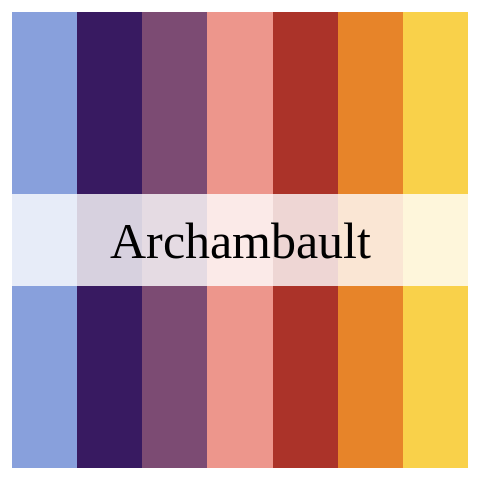

In [43]:
options(repr.plot.width=4, repr.plot.height=4)
met.brewer('Archambault')

In [37]:
##select subset of data for inset plot
plot1 <- plots %>%
            filter(plot_id %in% c('ZIS_2766', 'ZIS_2767', 'ZIS_2768', 'ZIS_2769')) %>%
            mutate(plot_area = '0.1 ha plot')

cent1 <- cent %>%
            filter(plot_id %in% c('ZIS_2766', 'ZIS_2767', 'ZIS_2768', 'ZIS_2769'))

cent_clust1 <- cent_clust %>% 
                     filter(plot_cluster %in% c('ZIS_2766'))

In [38]:
##select the realvant PAs
pas_map <- pas %>%
            st_intersection(zam) %>%
               mutate(protected_area = 'Protected Area') 

Warning message:
“attribute variables are assumed to be spatially constant throughout all geometries”


In [39]:
##convert bounding box to sf object
mbox1 <- st_as_sfc(st_bbox(plot1), crs = st_crs(crs(zam))) %>% 
            st_buffer(10)

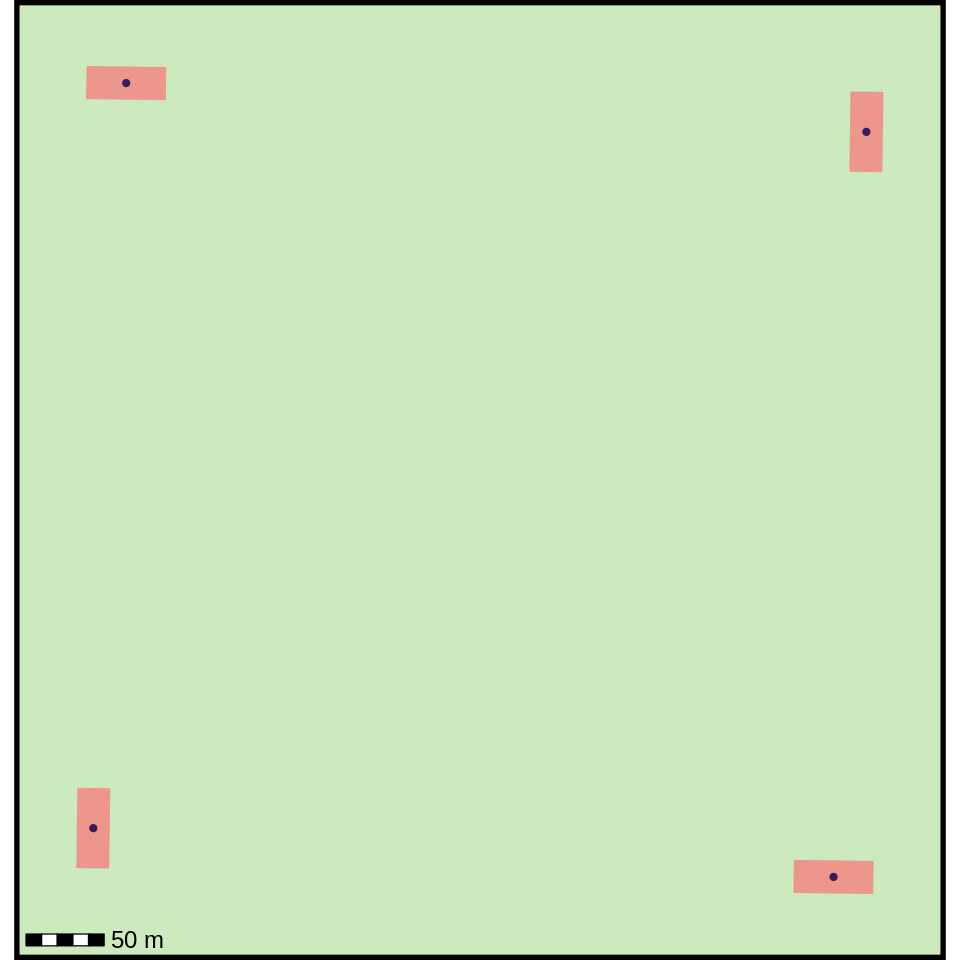

In [163]:
options(repr.plot.width=8, repr.plot.height=8)

(lil_map <- ggplot() +
                geom_sf(data= plot1, fill = pal[4], colour = pal[4]) +
                geom_sf(data = mbox1, fill = NA, colour = '#CCEABE') +
                geom_sf(data= cent1, colour = pal[2], size = 1, stroke = 1) +
                #geom_sf(data= cent_clust1, colour = pal[2], size = 1, stroke = 1) +
                theme_map() +
                coord_sf() +
                theme(legend.position = 'none', 
                      panel.background = element_rect(fill = '#CCEABE', colour = '#CCEABE'), 
                      panel.border = element_rect(colour = "black", fill=NA, size=3),
                      plot.margin = margin(t = 0, r = 0, b = 0, l = 0)) +
                annotation_scale( aes(style = 'bar', width_hint = 0.1), text_cex = 1.2, pad_y = unit(0.3, "cm"))

 
)           

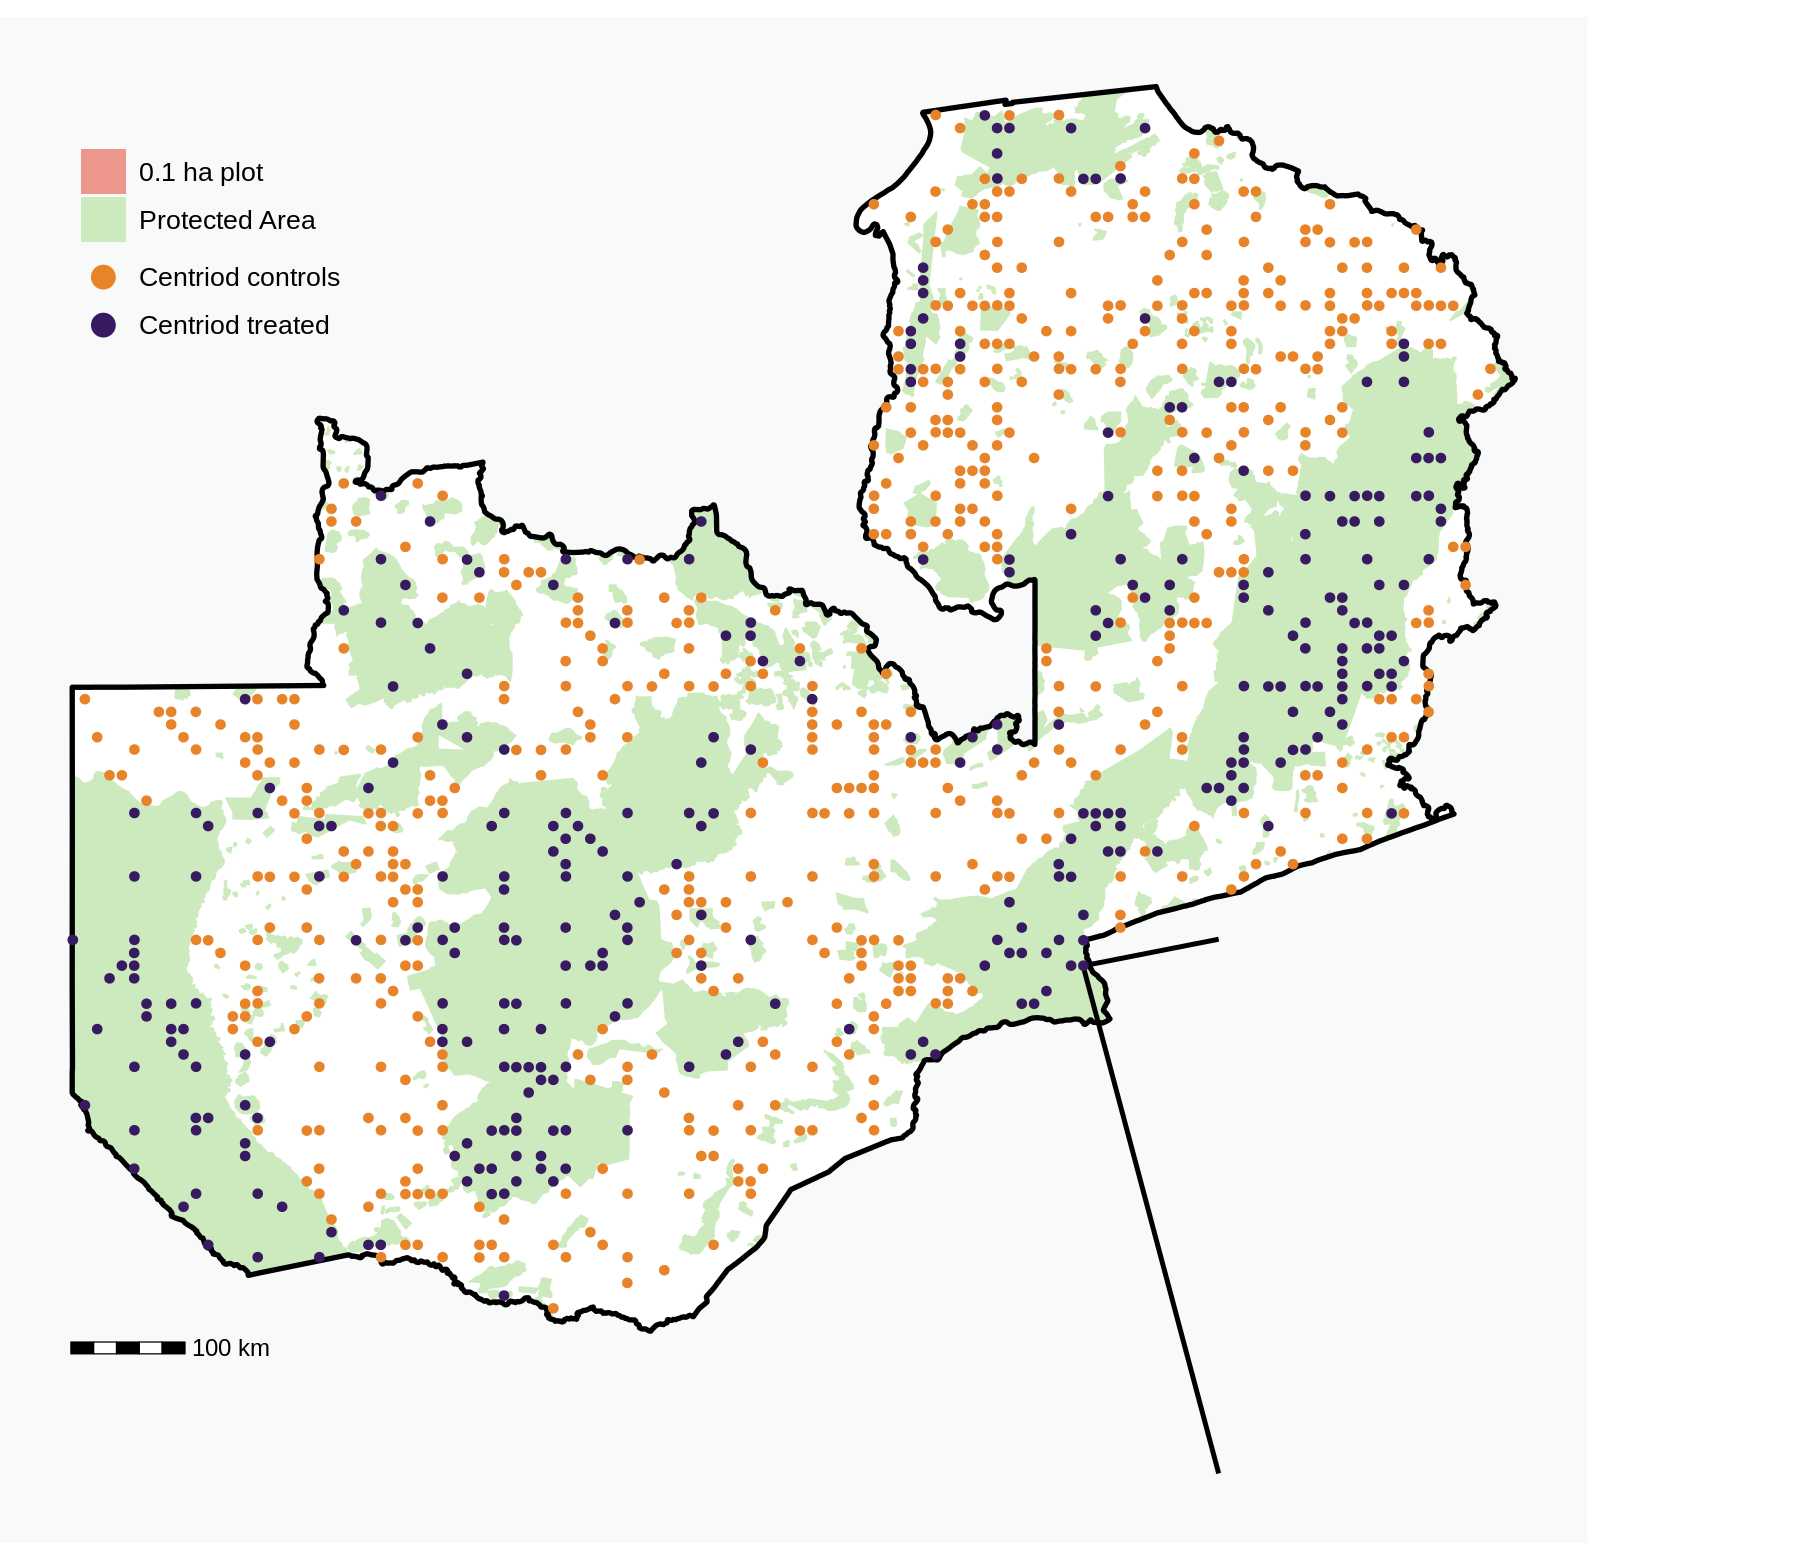

In [177]:
options(repr.plot.width=15, repr.plot.height=13)

(big_map <- ggplot() +
                geom_sf(data= zam, fill = 'white', size = 1) +
                geom_sf(data= plot1, aes(fill = plot_area), colour = pal[1]) +
                geom_sf(data= pas_map, aes(fill = protected_area), colour = '#CCEABE') +
                scale_fill_manual(values = c(pal[4], '#CCEABE')) +

             
                geom_sf(data = zam, fill = NA, size = 1.5, colour = 'black') +
 
                annotate("segment", x = 30.2, xend = 31.3, y = -15.2, yend = -14.99, colour = "black", size=1.4) +
                annotate("segment", x = 30.2, xend = 31.3, y = -15.2, yend = -19.2, colour = "black", size=1.4) +
                #annotate("segment", x = 30.2, xend = 34, y = -15.2, yend = -19.2, colour = "black", size=1.4) +

 
                geom_sf(data = cent_clust, aes(colour = as.factor(treatment)), size =1, stroke = 1.5) +
 
                scale_colour_manual(values = c(pal[6], pal[2]), labels = c('Centriod controls', 'Centriod treated')) +
                theme_map() +
                coord_sf() +
                theme(legend.title = element_blank(),
                      legend.text = element_text(size = 16),
                      legend.spacing.y = unit(0.1, 'cm'),
                      legend.position = c(0.05,0.85), 
                      plot.margin = margin(0, 4.5, 0, 0, "cm"),
                      panel.background = element_rect(fill = '#F8F9F9', colour = '#F8F9F9')) +
 
                guides(fill =guide_legend(keywidth = 2, keyheight = 2, override.aes = list(colour =NA)), 
                       col = guide_legend(keywidth = 2, keyheight = 2, override.aes = list(size=5))) +
 
                annotation_scale( aes(style = 'bar', width_hint = 0.1), text_cex = 1.2, pad_y = unit(4, "cm"), pad_x = unit(1.5, "cm"))

)

In [184]:
##read in shapefil of African countires for inlay map
africa <- st_read(dsn = paste0("/exports/csce/datastore/geos/users/s0834538/zam_match_data_final/",'ne_10m_admin_0_countries'), layer="ne_10m_admin_0_countries") %>%
            filter(CONTINENT == 'Africa') %>%
            mutate(zam = ifelse(NAME_SORT == 'Zambia', 1 ,0)) 

zam <- africa %>%
            filter(zam == 1) %>%
            mutate(zam = ifelse(NAME_SORT == 'Zambia', 1 ,0)) 

Reading layer `ne_10m_admin_0_countries' from data source 
  `/exports/csce/datastore/geos/users/s0834538/zam_match_data_final/ne_10m_admin_0_countries' 
  using driver `ESRI Shapefile'
Simple feature collection with 258 features and 161 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -180 ymin: -90 xmax: 180 ymax: 83.6341
Geodetic CRS:  WGS 84


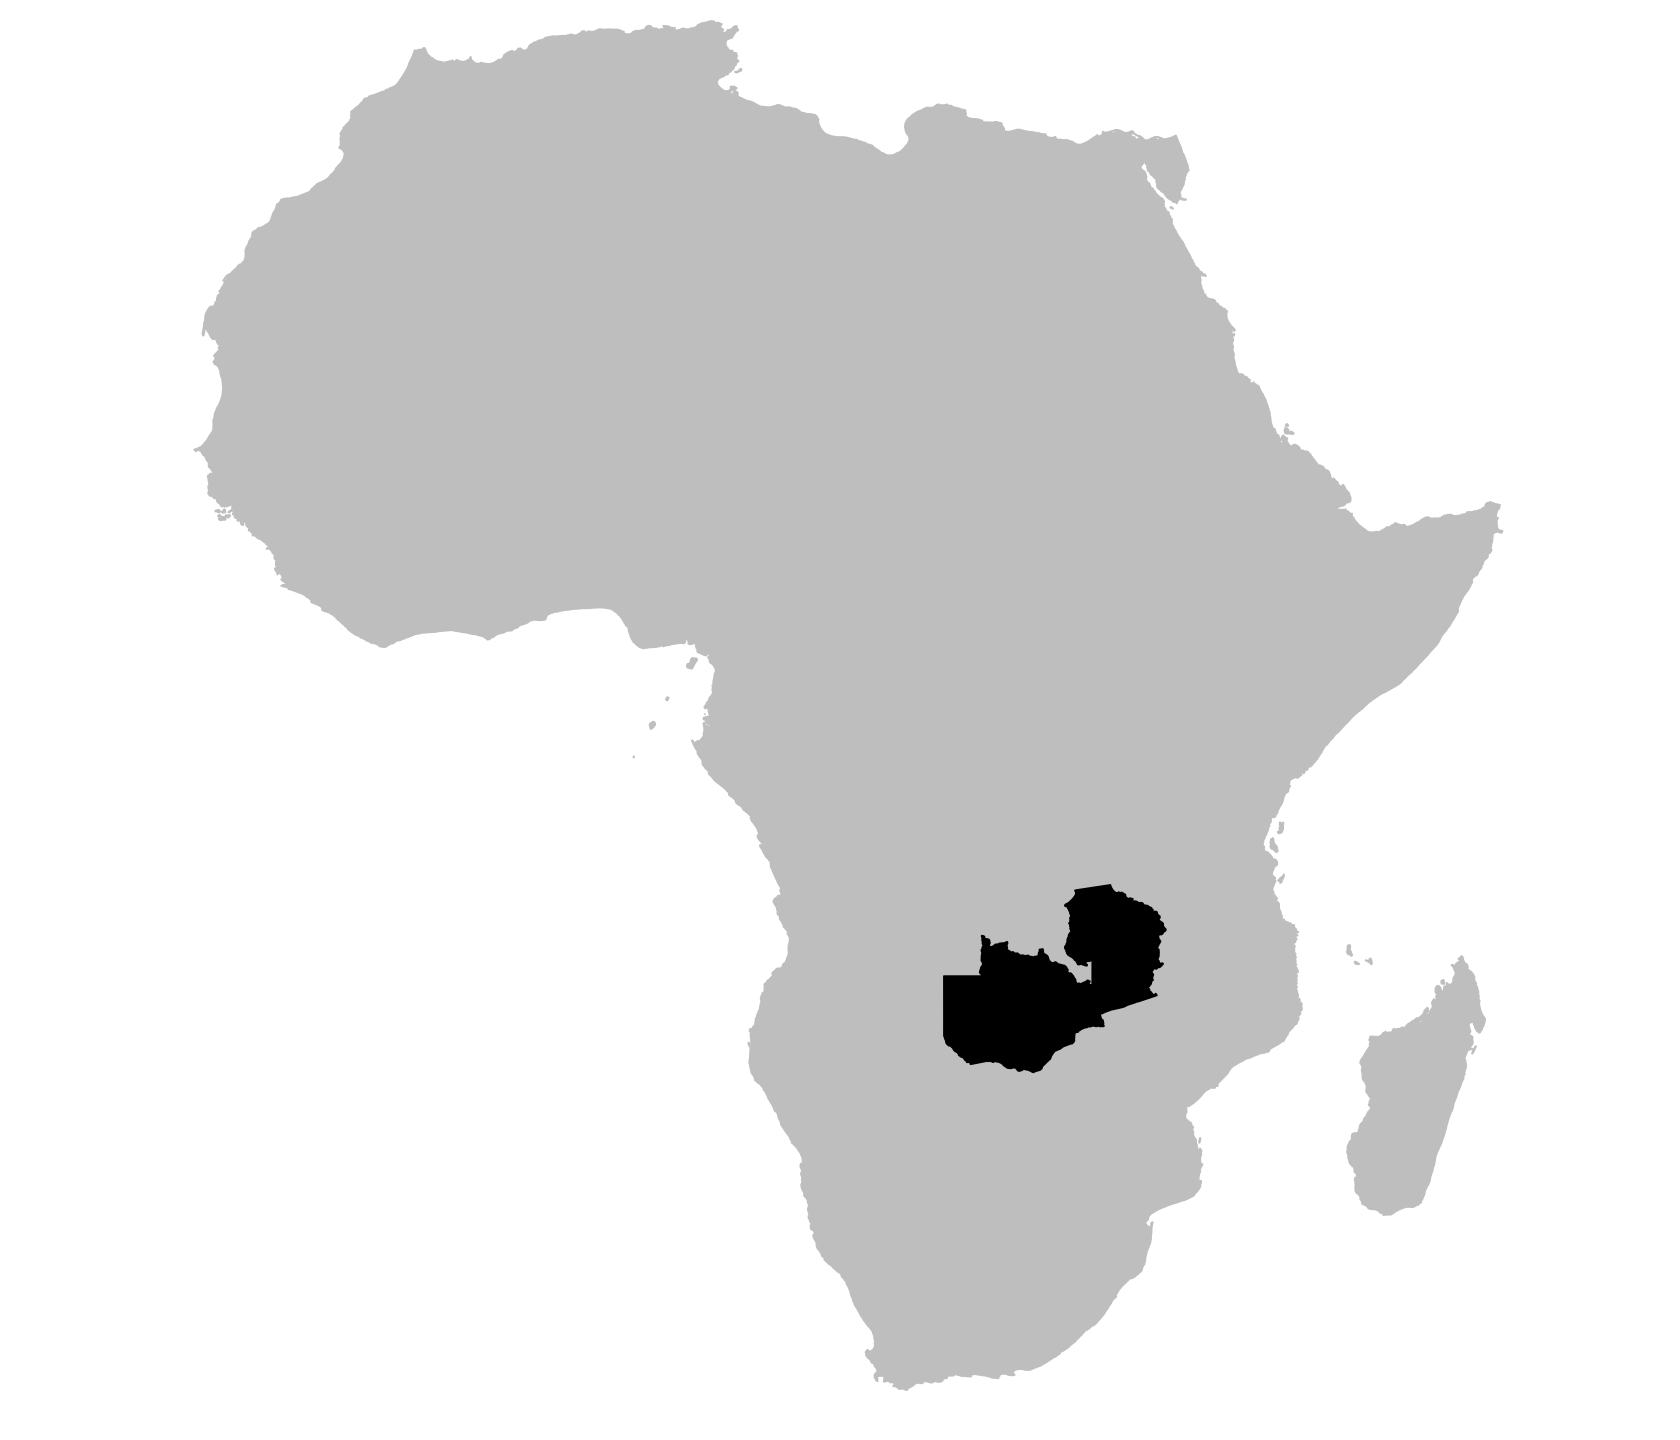

In [199]:
##create insert map of africa
(africa_map = ggplot() +
                geom_sf(data = africa, aes(fill = as.factor(zam), colour = as.factor(zam)), size = 0.5) +
                #geom_sf(data = zam, aes(), fill = 'black', colour = 'black', size = 0.7) +
                theme_map() +
                scale_fill_manual(values = c('grey','black')) +
                scale_colour_manual(values = c('grey','black')) +
                theme(legend.position = 'none', plot.margin = margin(t = 0, r = 0, b = 0, l = 0, unit = "pt"), 
                      panel.border = element_blank(), 
                     panel.background = element_blank()) +
               # geom_sf(data = bbox, colour = 'red', fill = NA, size= 1.3) +
                coord_sf(xlim=c(-17,50), ylim =c(-34,35)) 
)

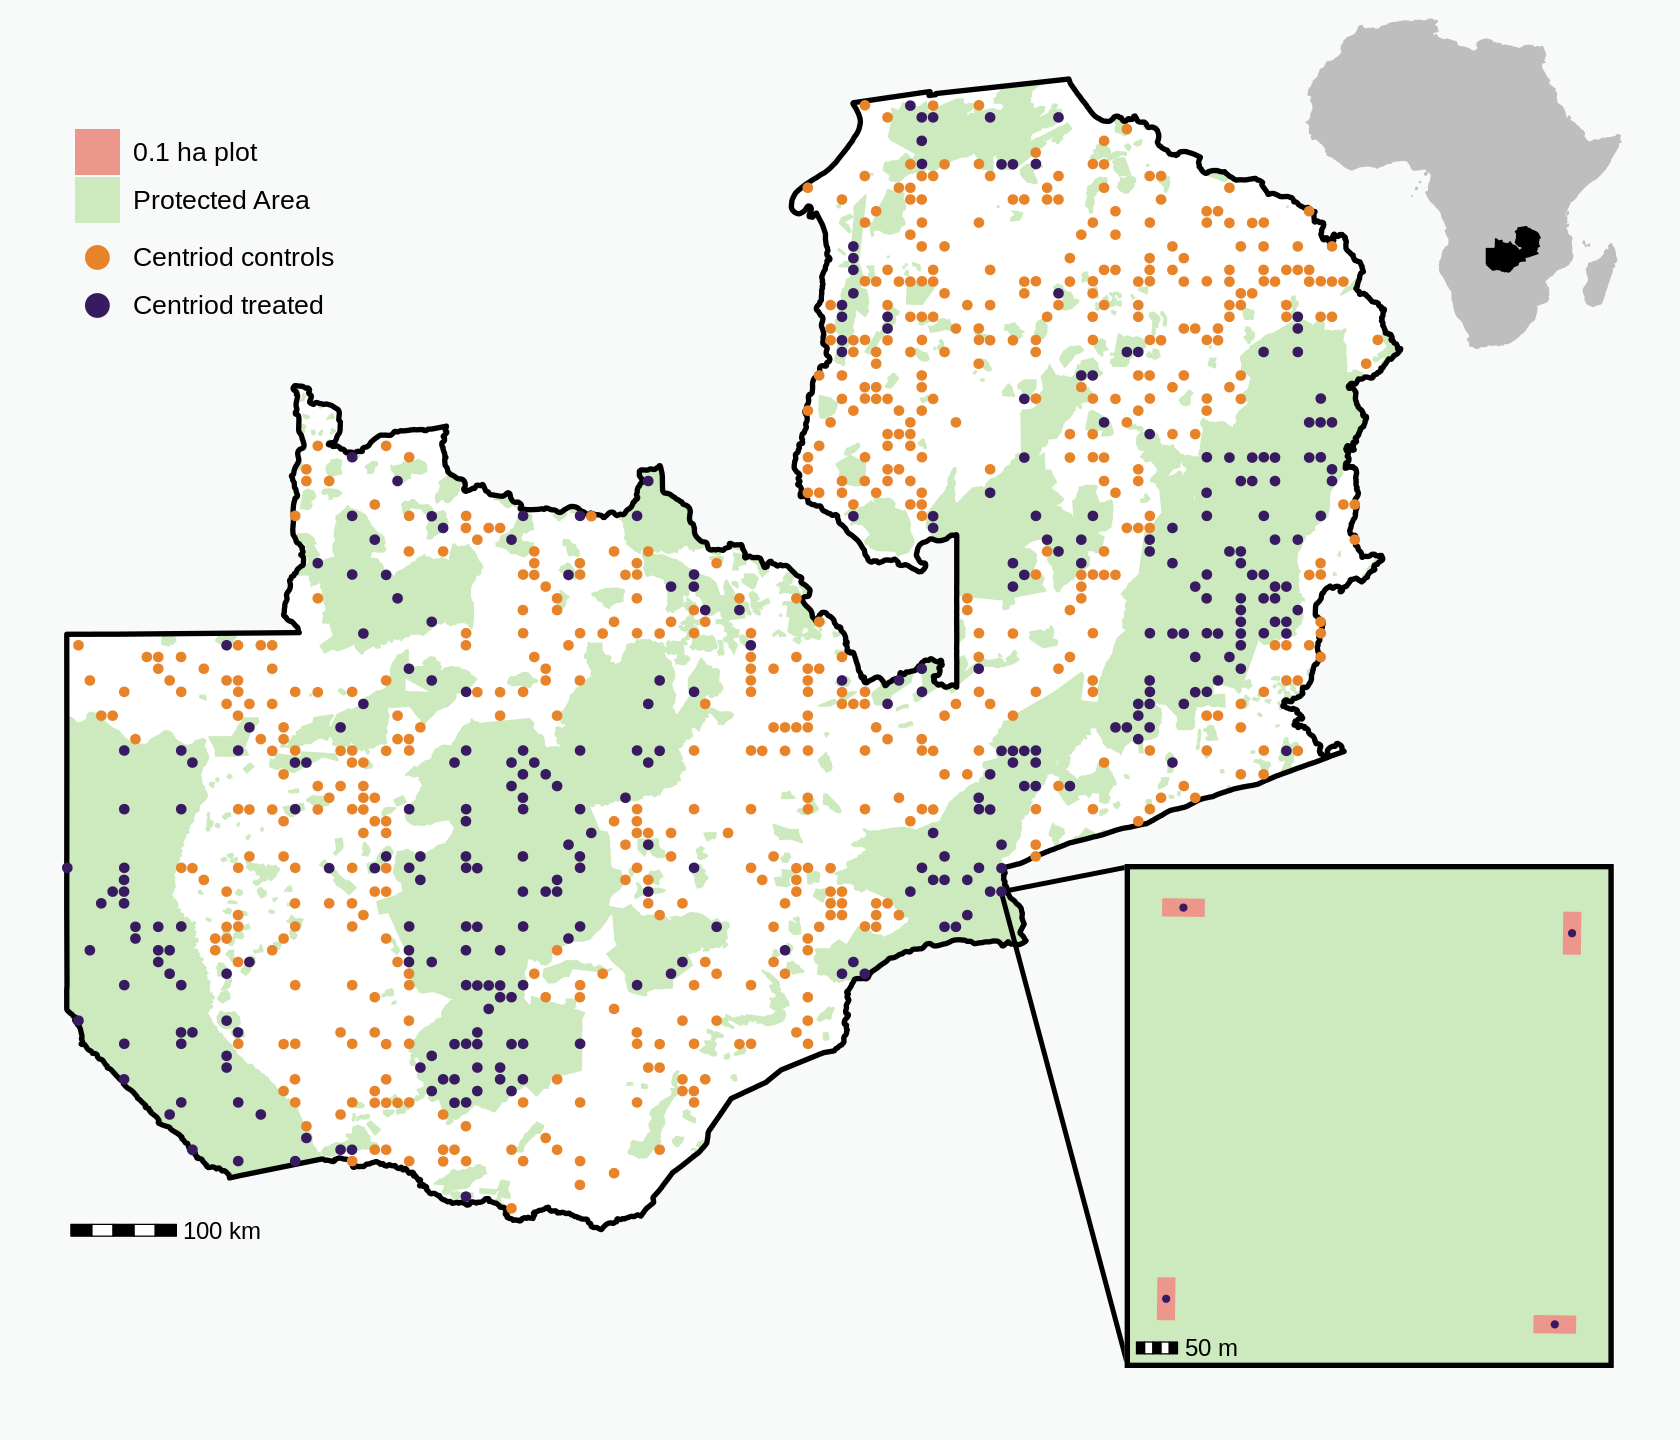

In [201]:
options(repr.plot.width=14, repr.plot.height=12)

(inset_map = ggdraw() +
  draw_plot(big_map) +
  draw_plot(lil_map, x = 0.64, y = 0.05, width = 0.35, height = 0.35) +
  draw_plot(africa_map, x = 0.77, y = 0.67, width = 0.2, height = 0.4) +
  theme(plot.background = element_rect(fill='#F8F9F9', color = NA))
)

In [202]:
#save file
ggsave(inset_map, 'png', filename = 'figures/figure1.png', width = 14, height = 12)

In [1]:
R.version

               _                           
platform       x86_64-conda-linux-gnu      
arch           x86_64                      
os             linux-gnu                   
system         x86_64, linux-gnu           
status                                     
major          4                           
minor          0.5                         
year           2021                        
month          03                          
day            31                          
svn rev        80133                       
language       R                           
version.string R version 4.0.5 (2021-03-31)
nickname       Shake and Throw             